# AirBnb listings file modeling

In [6]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import os
import seaborn as sns
import pandas as pd
import math

import sklearn.model_selection as cv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [8]:
data_path = os.path.join(os.getcwd(), "../data/cleaned_listings.csv")
listings = pd.read_csv(data_path, index_col="id")
display(listings.shape)

(48855, 65)

### Plot the dstribution

Let's plot the percentile for price

Text(0, 0.5, 'Price')

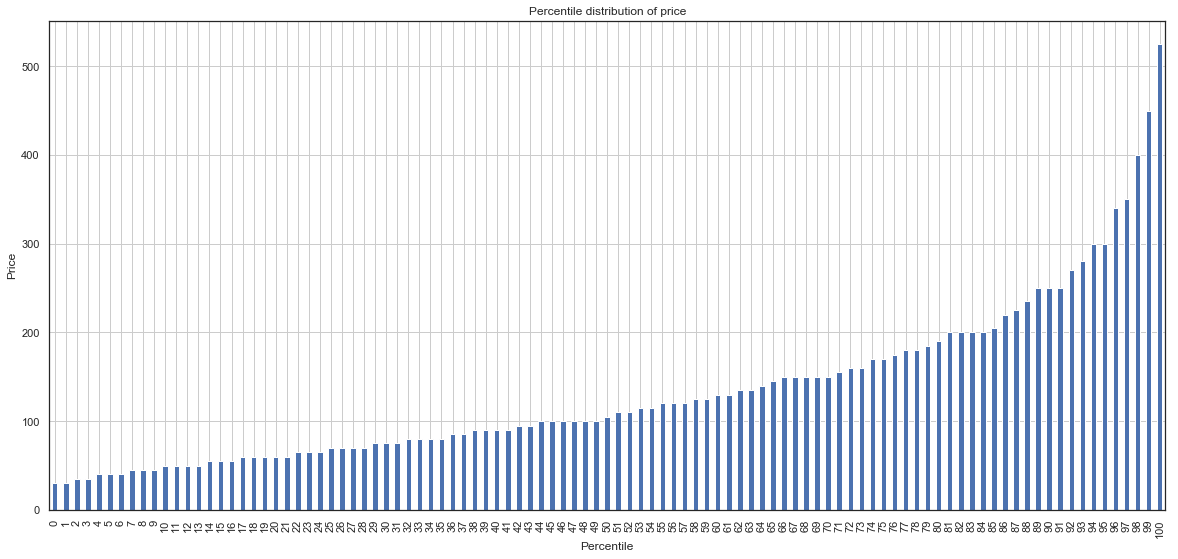

In [9]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

sns.set(style="white")
price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(20,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

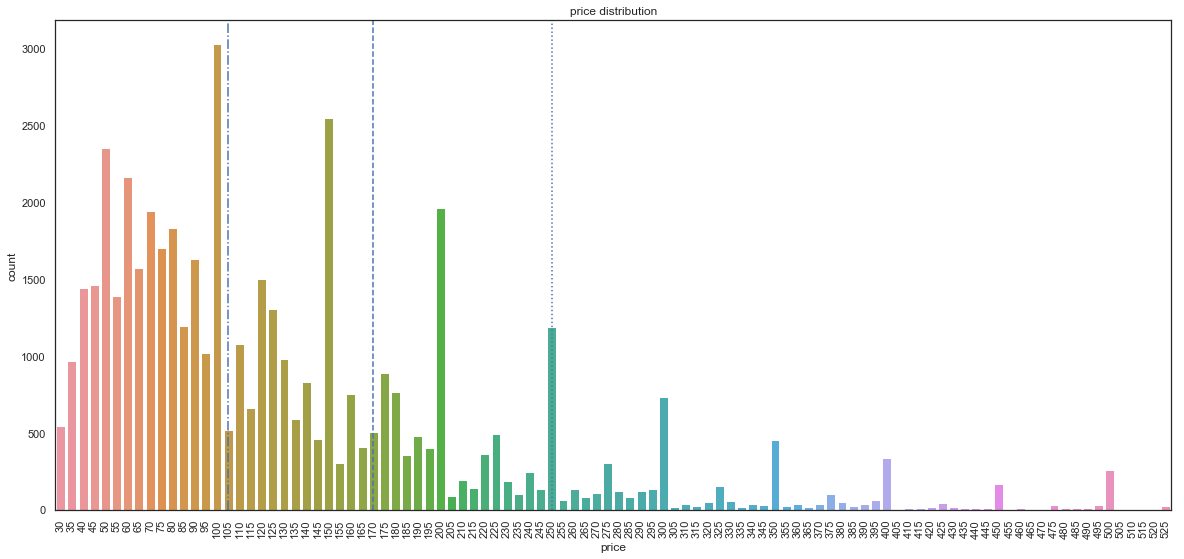

In [10]:
f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.countplot(x="price", data=listings, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")
median_idx = np.where(np.sort(listings["price"].unique())==listings["price"].median())
plt.axvline(x=median_idx, linestyle="-.")
percentile_75_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[75,:].values[0])
plt.axvline(x=percentile_75_idx, linestyle="--")
percentile_90_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[90,:].values[0])
plt.axvline(x=percentile_90_idx, linestyle=":")

------------------

Quick helper functions

In [11]:
def roundto(row, base=5):
    return int(base * round(float(row) / base))

# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

### 1. Oversampling using SMOTE

In [12]:
def check_rep(row):
    if (row <= 200) | (row==250) | (row==350) | (row==450) | (row==550) :
        return 0
    elif (row > 200) & (row < 300) & (row != 250):
        return 1 
    elif (row > 300) & (row < 400) & (row != 350):
        return 2 
    else:
        return 3 

listings["flag_ur"] = listings["price"].apply(check_rep)

In [13]:
vcs = listings["flag_ur"].value_counts()
vcs

0    43321
1     3093
3     1624
2      817
Name: flag_ur, dtype: int64

In [14]:
ycol = ["flag_ur"]
xcol = [i for i in listings.columns if i not in ycol]

x = listings[xcol].values
y = listings[ycol].values

smote_sampling_strategy = {
    1: int(vcs[1]*2)
    ,2: int(vcs[2]*2)
    ,3: int(vcs[3]*2)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)
# Fit the smote onto the sample
x_new, y_new = sm.fit_sample(x, y)

# Drop the flag column
listings.drop(labels=["flag_ur"], axis=1, inplace=True)

# ---------------------------------------------------------------------------------------------------------
# Overwrite X and Y
price_index = get_index(list(listings.columns), "price")

y = x_new[:, price_index]
x = np.delete(x_new, price_index, axis=1)
for i in range(len(y)):
    y[i] = roundto(y[i])

In [15]:
print(
    " Old size :", listings.shape, "\n",
    "New size :", x.shape
)

 Old size : (48855, 65) 
 New size : (54389, 64)


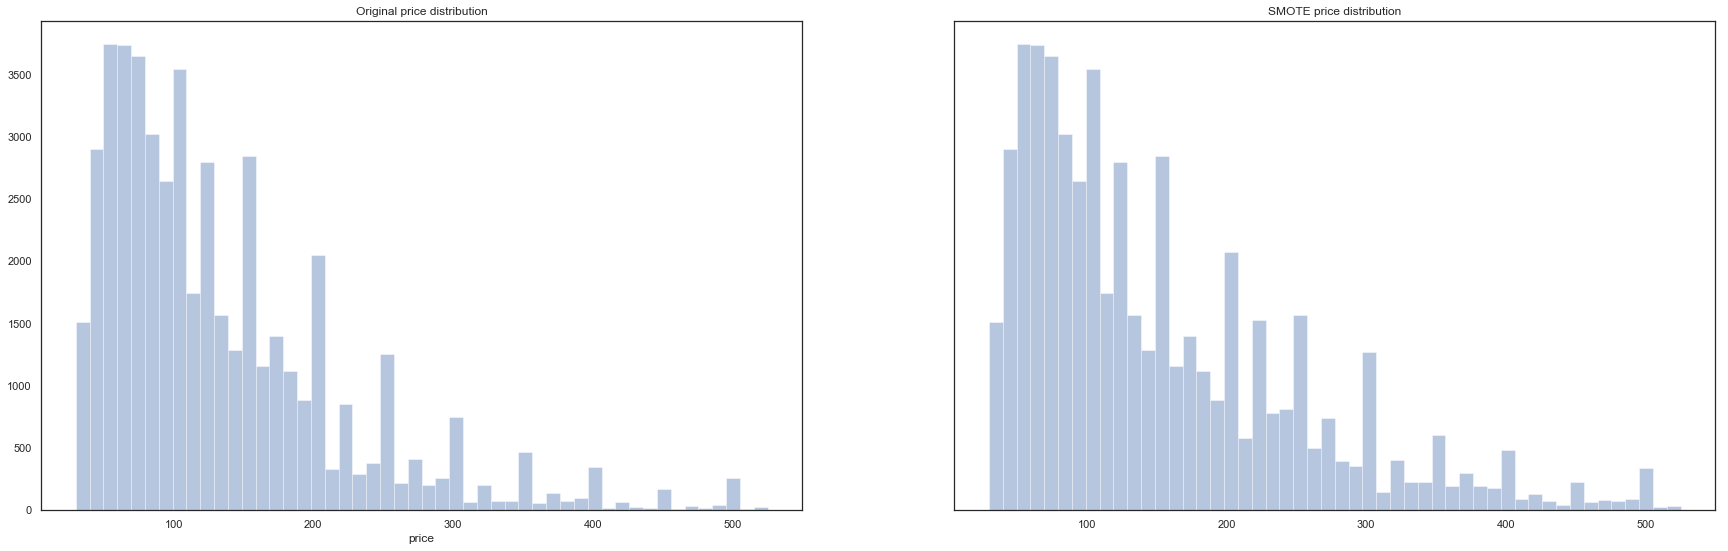

In [16]:
f, ax = plt.subplots(1, 2, figsize=(30, 9), sharey=True)
g1 = sns.distplot(listings["price"], ax=ax[0], kde=False)
t = g1.set_title("Original price distribution")

g2 = sns.distplot(y, ax=ax[1], kde=False)
t = g2.set_title("SMOTE price distribution")


### 2. Transformation

In [17]:
x_cols = listings.drop(['price'], axis=1)
X = pd.DataFrame(data=x, columns=x_cols.columns)

In [18]:
X_log = X.copy()
X_sqr = X.copy()
X_sqrt = X.copy()

In [19]:
# Taking log, square and square root transformations of x
for i in range(X_log.shape[1]):
    X_log.iloc[:,i] = np.log(X_log.iloc[:,i] + 1)
    X_sqr.iloc[:,i] = np.square(X_sqr.iloc[:,i])
    X_sqrt.iloc[:,i] = np.sqrt(X_sqrt.iloc[:,i])
X_log.columns = X_log.columns.map(lambda x: x + '_log')
X_sqr.columns = X_sqr.columns.map(lambda x: x + '_sqr')
X_sqrt.columns = X_sqrt.columns.map(lambda x: x + '_sqrt')

In [20]:
X_sqrt.shape

(54389, 64)

In [21]:
# Appending X, X_log, X_sqr and X_sqrt
X_final = pd.concat([X, X_log, X_sqr, X_sqrt], axis=1)
X_final.shape

(54389, 256)

### Prediction

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_SEED)

In [23]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE with Transformation: {:.2f}".format(rmse_train))
print("Test set RMSE with Transformation: {:.2f}".format(rmse_test))

Train set RMSE with Transformation: 24.25
Test set RMSE with Transformation: 56.60


In [24]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(rfr, x_train, y_train, scoring='neg_mean_squared_error', cv=10)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE with Transformation: {:.2f}'.format(CV))

Cross Validation RMSE with Transformation: 57.38


### 3. Train test split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=RANDOM_SEED)

### 4. Standardisation

In [26]:
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

### 5. PCA

Number of components :  49


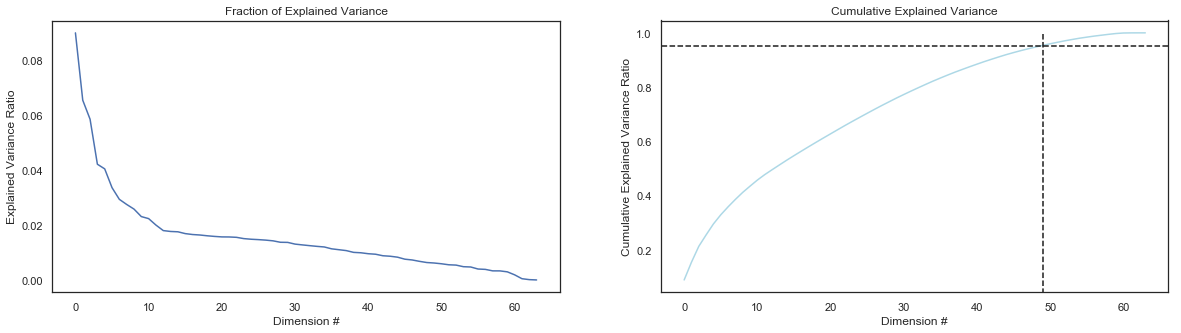

In [27]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)
print("Number of components : ", num_pc)

In [28]:
# pca = PCA(n_components=num_pc)
pca = PCA(n_components=None)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Prediction

### Random Forest Regressor

#### With PCA

In [29]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE with PCA: {:.2f}".format(rmse_train))
print("Test set RMSE with PCA: {:.2f}".format(rmse_test))

Train set RMSE with PCA: 26.72
Test set RMSE with PCA: 62.94


In [30]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(rfr, x_train_pca, y_train, scoring='neg_mean_squared_error', cv=10)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE with PCA: {:.2f}'.format(CV))

Cross Validation RMSE with PCA: 63.11


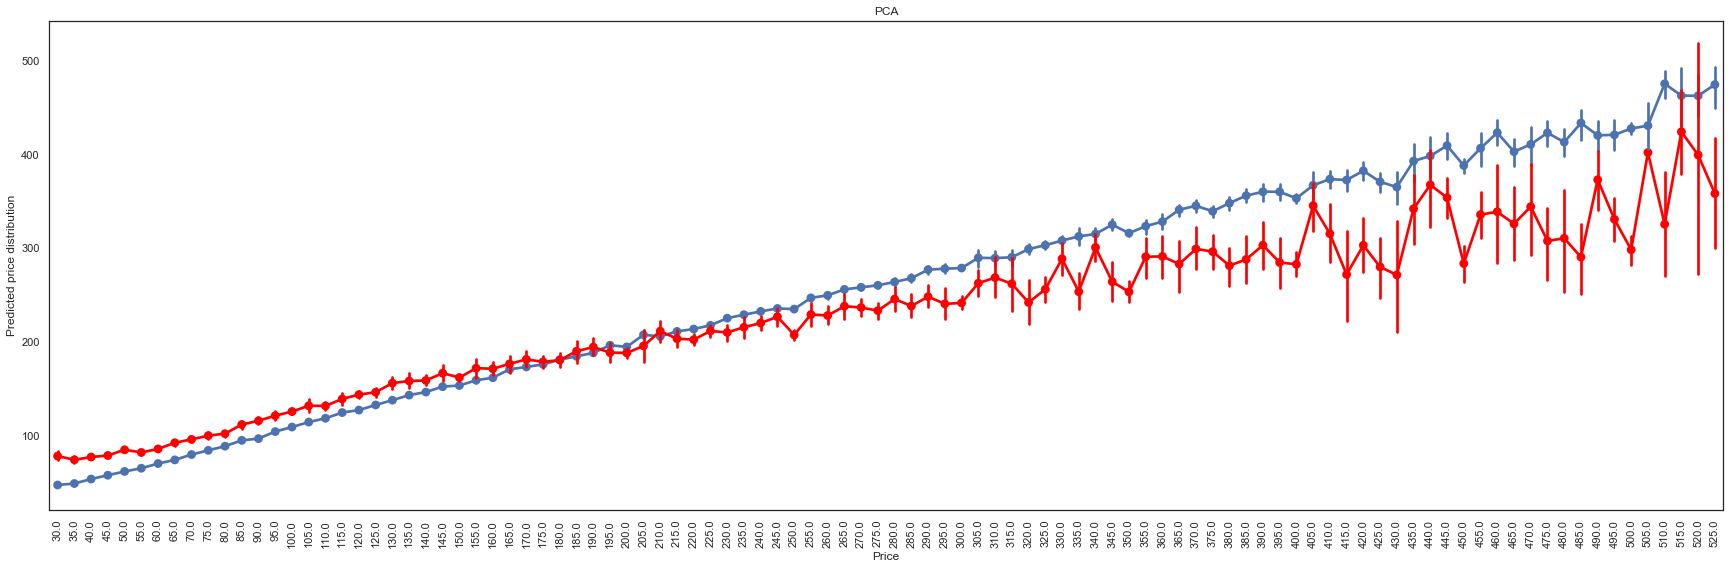

In [31]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("PCA")

## 6. ML Algorithms

### a. Ridge Regression

### b. Lasso Regression

### c. Decision Trees

#### Initial Baseline

In [184]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)
dtr.fit(X=x_train, y=y_train)
y_pred_train = dtr.predict(X=x_train)
y_pred_test = dtr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 1.75
Test set RMSE Scaled: 78.63


In [185]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(dtr, x_train, y_train, scoring='neg_mean_squared_error', cv=10)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 78.11


#### Individual Parameter Tuning 

##### max_depth

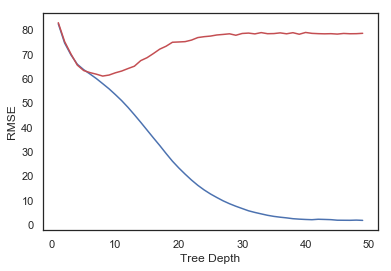

In [63]:
max_depths = np.arange(1, 50, 1)
train_results = []
test_results = []
for test_depth in max_depths:
    
    dt = DecisionTreeRegressor(random_state=RANDOM_SEED,max_depth=test_depth)
    
    dt.fit(X=x_train, y=y_train)

    train_pred = dt.predict(X=x_train)
    train_mse = MSE(y_train, train_pred)
    train_results.append(train_mse**(1/2))
    
    y_pred = dt.predict(x_test)
    test_mse = MSE(y_test, y_pred)
    test_results.append(test_mse**(1/2))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depths, test_results, 'r', label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('Tree Depth')
plt.show()

##### max_features

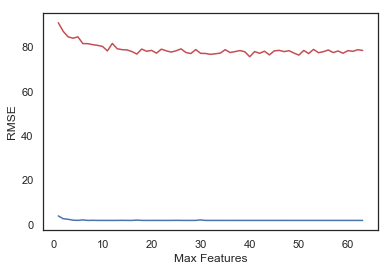

In [195]:
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []
for max_feat_test in max_features:
    
    dt = DecisionTreeRegressor(random_state=RANDOM_SEED,max_features=max_feat_test)
    
    dt.fit(X=x_train, y=y_train)

    train_pred = dt.predict(X=x_train)
    train_mse = MSE(y_train, train_pred)
    train_results.append(train_mse**(1/2))
    
    y_pred = dt.predict(x_test)
    test_mse = MSE(y_test, y_pred)
    test_results.append(test_mse**(1/2))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_features, test_results, 'r', label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('Max Features')
plt.show()

##### min_samples_splits

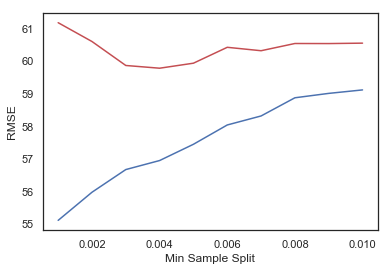

In [192]:
min_samples_splits = np.linspace(0.001, 0.01, 10, endpoint=True)

train_results = []
test_results = []
for min_samp_test in min_samples_splits:
    
    dt = DecisionTreeRegressor(random_state=RANDOM_SEED,max_depth=10,min_samples_split=min_samp_test)
    
    dt.fit(X=x_train, y=y_train)

    train_pred = dt.predict(X=x_train)
    train_mse = MSE(y_train, train_pred)
    train_results.append(train_mse**(1/2))
    
    y_pred = dt.predict(x_test)
    test_mse = MSE(y_test, y_pred)
    test_results.append(test_mse**(1/2))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train RMSE')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('Min Sample Split')
plt.show()

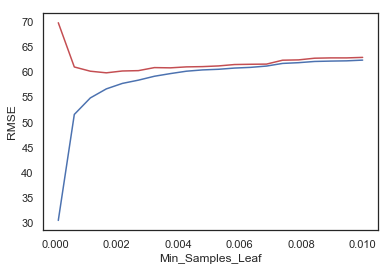

In [199]:
min_samples_leafs = np.linspace(0.0001, 0.01, 20, endpoint=True)

train_results = []
test_results = []
for min_samp_leaf_test in min_samples_leafs:
    
    dt = DecisionTreeRegressor(random_state=RANDOM_SEED,min_samples_leaf=min_samp_leaf_test)
    
    dt.fit(X=x_train, y=y_train)

    train_pred = dt.predict(X=x_train)
    train_mse = MSE(y_train, train_pred)
    train_results.append(train_mse**(1/2))
    
    y_pred = dt.predict(x_test)
    test_mse = MSE(y_test, y_pred)
    test_results.append(test_mse**(1/2))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train RMSE')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test RMSE')
plt.ylabel('RMSE')
plt.xlabel('Min_Samples_Leaf')
plt.show()

#### GridSearch

In [201]:
grid_search.fit(x_test, y_test)

Fitting 3 folds for each of 8000 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2457 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3917 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5697 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7805 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10233 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 12989 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 16065 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 19469 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 23193 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 23993 out of 24000 | elapsed:  9.4min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  9.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [10, 20, 30, 40, 50], 'min_samples_leaf': [0.0001, 0.0006210526315789474, 0.0011421052631578948, 0.0016631578947368423, 0.0021842105263157894, 0.0027052631578947366, 0.0032263157894736843, 0.0037473684210526316, 0.0042684210526...amples_split': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [202]:
grid_search.best_params_

{'max_depth': 14,
 'max_features': 50,
 'min_samples_leaf': 0.0011421052631578948,
 'min_samples_split': 0.01}

#### Final Decision Tree Model

In [203]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=RANDOM_SEED,max_depth=14,max_features=50,min_samples_leaf=0.001142,min_samples_split=0.01)
dtr.fit(X=x_train, y=y_train)
y_pred_train = dtr.predict(X=x_train)
y_pred_test = dtr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 58.78
Test set RMSE Scaled: 59.99


In [205]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(dtr, x_train, y_train, scoring='neg_mean_squared_error', cv=10)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 61.04


### d. Random Forests

In [123]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 23.93
Test set RMSE Scaled: 55.97


In [124]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(rfr, x_train, y_train, scoring='neg_mean_squared_error', cv=10)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 56.82


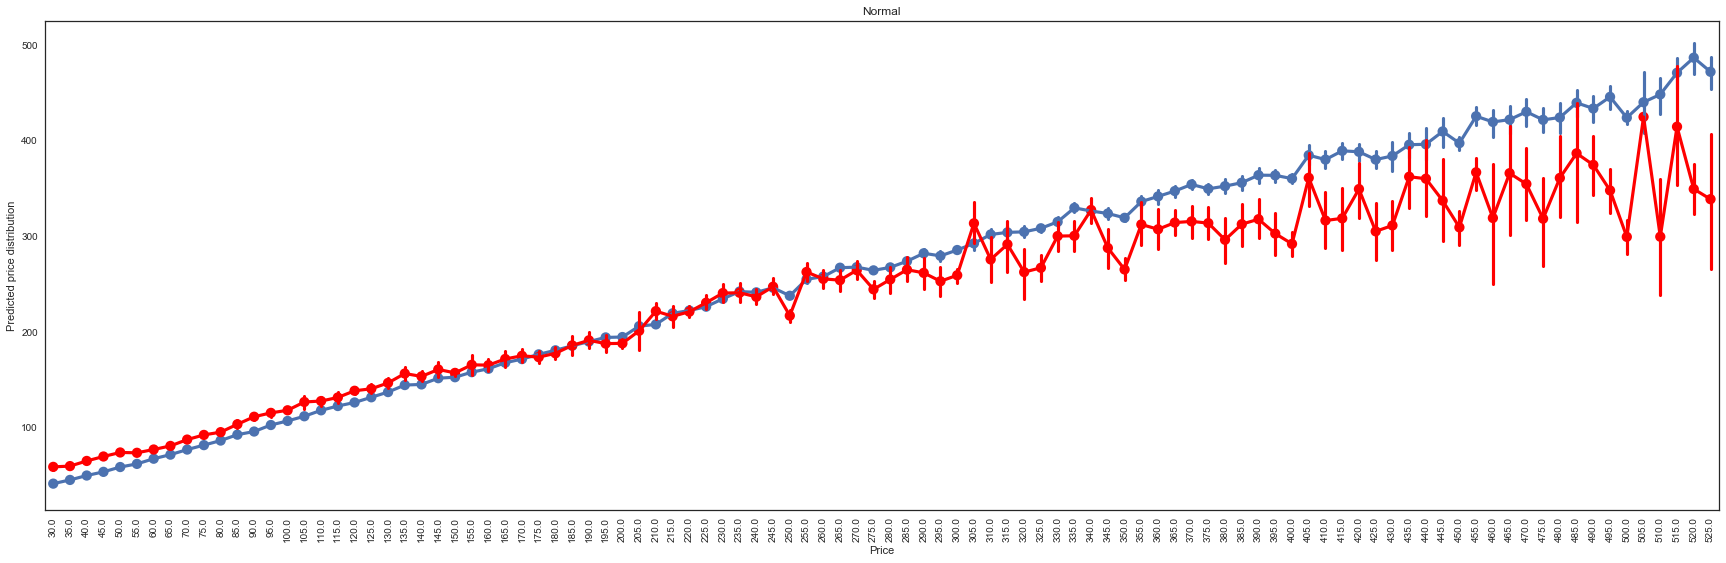

In [105]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

#### Feature Importance

In [106]:
x_final = listings.drop(['price'], axis=1)

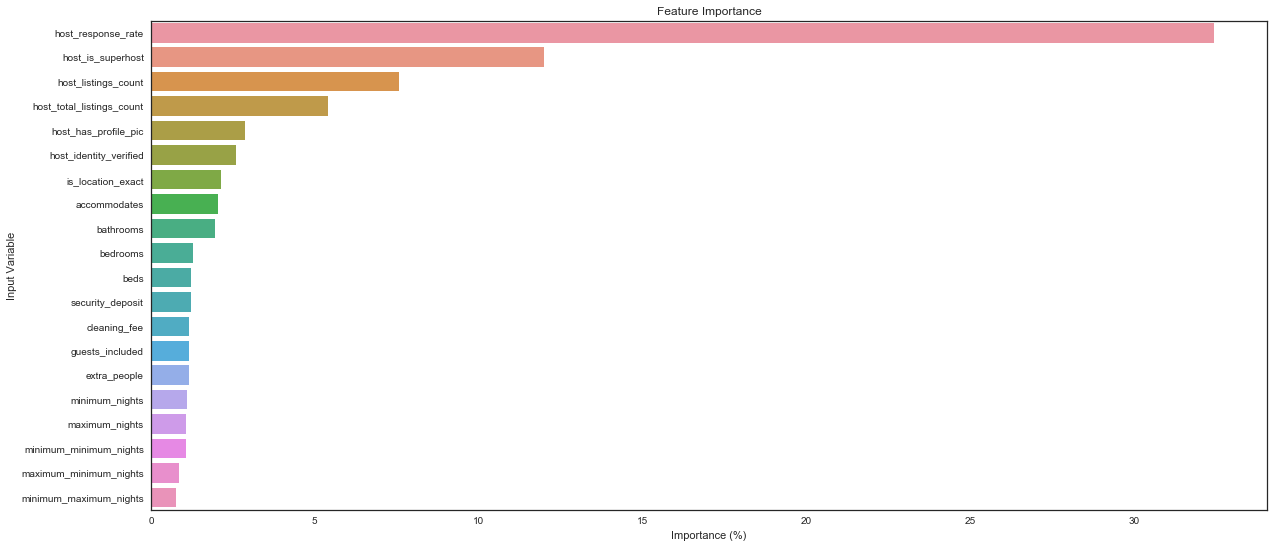

In [107]:
imp = pd.DataFrame({'Input Variable': x_final.columns, 'Importance (%)': -np.sort(-100*rfr.feature_importances_)})
top20 = imp.iloc[:20,:]

f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.barplot(x="Importance (%)", y="Input Variable", data=top20, ax=ax)
t = g.set_xlabel("Importance (%)")
t = g.set_ylabel("Input Variable")
t = g.set_title("Feature Importance")

### e. Gradient Boosting